In [38]:
import cPickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from IPython import display
import scipy.sparse as sp
from scipy.stats import pearsonr
%matplotlib inline

In [3]:
with open("../data/modis.pkl") as fpd:
    modis = cPickle.load(fpd)
print "loaded pandas database with %d points" %len(modis)
with open("../data/gfs_temp_2013.pkl") as ftemp:
    temp_tensor = cPickle.load(ftemp)
print "Loaded tensor of dimensions " + str(temp_tensor.shape)

loaded pandas database with 31697705 points
Loaded tensor of dimensions (181, 360, 365)


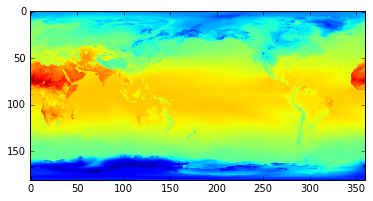

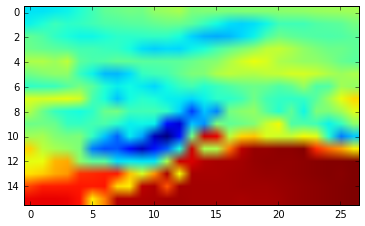

In [4]:
# Make sure we can plot temp_tensor properly
ak_bb = [90-55, 90-71, -165, -138]
plt.imshow(temp_tensor[:,:,100])
plt.show()
plt.imshow(temp_tensor[ak_bb[1]:ak_bb[0], ak_bb[2]:ak_bb[3], 100])
plt.show()
def monthday2day(month, day, leapyear=False):
    """Convert month/day into days since Jan 1"""
    if leapyear:
        month_arr = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    else:
        month_arr = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    days = 0
    for mon in xrange(1, month):
        days += month_arr[mon - 1]
    days += day - 1
    return days

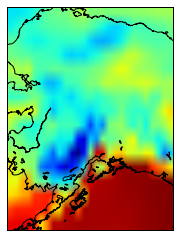

In [11]:
mp = Basemap(projection="merc",
              lat_0=55, lon_0=-165,
              llcrnrlat=55,
              llcrnrlon=-165,
              urcrnrlat=71,
              urcrnrlon=-138,
              resolution='i')
mp.drawcoastlines()
mp.imshow(temp_tensor[(89-55):(89-71):-1, -165:-138, 100])
plt.show()

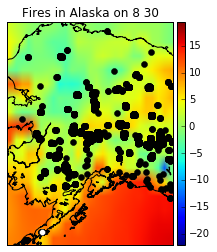

In [66]:
# Plot AK fires over time with temperature overlayed
ak_bb = [55, 71, -165, -138]
ak_bb_plotter = [90-55, 90-71, -165, -138]
ak_fires = modis[(modis.lat < ak_bb[1]) & (modis.lat > ak_bb[0]) &
                 (modis.long < ak_bb[3]) & (modis.long > ak_bb[2])]
summer_beg = monthday2day(6,1)
summer_end = monthday2day(9,1)
min_temp = np.min(temp_tensor[(89-55):(89-71):-1, -165:-138, summer_beg:summer_end]) - 273
max_temp = np.max(temp_tensor[(89-55):(89-71):-1, -165:-138, summer_beg:summer_end]) - 273
print "min_temp/max_temp: " + str((min_temp,max_temp))
month = 6
day = 1
prev_lats = []
prev_longs = []
while month < 9:
    todays_fires = ak_fires[(ak_fires.year == 2013) & (ak_fires.month == month) &
                            (ak_fires.day == day)]
    day_in_year = monthday2day(month, day, leapyear=False)
    display.clear_output(wait=True)
    mp = Basemap(projection="merc",
              lat_0=55, lon_0=-165,
              llcrnrlat=55,
              llcrnrlon=-165,
              urcrnrlat=71,
              urcrnrlon=-138,
              resolution='i')
    mp.drawcoastlines()
    mp.imshow(temp_tensor[(89-55):(89-71):-1, -165:-138, day_in_year] - 273,    
              vmin=min_temp, vmax=max_temp)
    mp.colorbar()
    if len(prev_lats):
        mp.plot(prev_longs, prev_lats, 'ko')
    if len(todays_fires):
        today_longs, today_lats = mp(np.array(todays_fires.long), np.array(todays_fires.lat))
        mp.plot(today_longs, today_lats, 'wo')
        prev_lats += list(today_lats)
        prev_longs += list(today_longs)
    plt.title("Fires in Alaska on %d %d" %(month, day))
    plt.show()
    #time.sleep(1)
    day += 1
    if day >= 31 or (day >= 30 and month == 6):
        day = 1
        month += 1

In [19]:
print "Min Alaska temp: " + str(np.min(temp_tensor[(89-55):(89-71):-1, -165:-138,:]) - 273)
print "Max Alaska temp: " + str(np.max(temp_tensor[(89-55):(89-71):-1, -165:-138,:]) - 273)

Min Alaska temp: -53.2
Max Alaska temp: 19.5


In [51]:
# clustering
deg_thresh = .05
ak_fires_2013 = ak_fires[ak_fires.year == 2013]
N = len(ak_fires_2013)
thresh_graph = sp.lil_matrix((N,N))
lat_long_mat = np.transpose(np.array((np.array(ak_fires_2013.lat),np.array(ak_fires_2013.long))))
print "lat_long_mat shape: " + str(lat_long_mat.shape)
for i in xrange(N):
    p_i = np.array([ak_fires_2013.iloc[i].lat, ak_fires_2013.iloc[i].long])
    dist_arr = np.linalg.norm(lat_long_mat - p_i, axis=1)
    thresh_arr = dist_arr < deg_thresh
    thresh_graph[i,:] = thresh_arr
    if i % 1000 == 0:
        print "finished %d of %d" %(i, N)
pre_n_CCs, pre_CCs = sp.csgraph.connected_components(thresh_graph, directed=False)
# Kill singleton/double clusters
n_CCs = 0
CCs = np.zeros(N) + np.inf
for clust in xrange(pre_n_CCs):
    if len(np.where(pre_CCs == clust)[0]) > 2:
        CCs[np.where(pre_CCs == clust)] = n_CCs
        n_CCs += 1
print "Found %d clusts" % n_CCs

lat_long_mat shape: (9588, 2)
finished 0 of 9588
finished 1000 of 9588
finished 2000 of 9588
finished 3000 of 9588
finished 4000 of 9588
finished 5000 of 9588
finished 6000 of 9588
finished 7000 of 9588
finished 8000 of 9588
finished 9000 of 9588
Found 99 clusts


15 nans


/Users/zbutler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


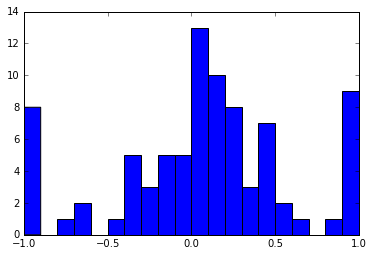

mean correlation: 0.0718313633244
number above 0: 54, number below 0: 30


/Users/zbutler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


In [52]:
# Now, let's look at the correlation between fire frequency and temperature
corrs = np.zeros(n_CCs)
for clust in xrange(n_CCs):
    clust_fires = ak_fires_2013.iloc[np.where(CCs == clust)]
    mean_lat_int = int(np.mean(clust_fires.lat))
    mean_long_int = int(np.mean(clust_fires.long))
    time_arr = np.zeros(len(clust_fires))
    for i,(month,day) in enumerate(zip(clust_fires.month, clust_fires.day)):
        my_day = monthday2day(month, day, leapyear=False)
        time_arr[i] = my_day
    max_day = int(np.max(time_arr))
    min_day = int(np.min(time_arr))
    fire_time_series = np.zeros(max_day-min_day+1)
    weather_time_series = np.zeros(max_day-min_day+1)
    for i,day in enumerate(xrange(min_day, max_day+1)):
        fire_time_series[i] = np.sum(time_arr == day)
        weather_time_series[i] = temp_tensor[90-mean_lat_int, mean_long_int, day]
    corrs[clust] = pearsonr(fire_time_series, weather_time_series)[0]
nans = np.isnan(corrs)
print "%d nans" % np.sum(nans)
plt.hist(corrs[True - nans], bins=20)
plt.show()
print "mean correlation: " + str(np.mean(corrs[True-nans]))
print "number above 0: %d, number below 0: %d" % (np.sum(corrs > 0), np.sum(corrs < 0))

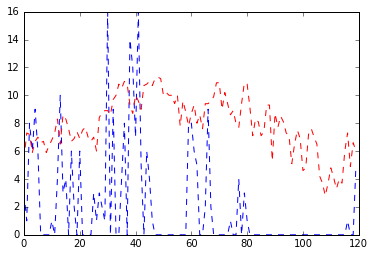

corr: (0.15947965370769154, 0.081880073580450602)


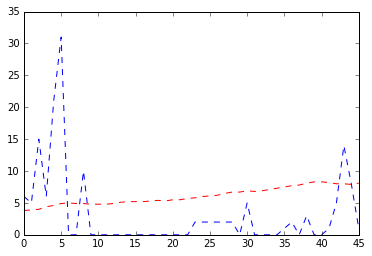

corr: (-0.19829409726073119, 0.18648605695646156)


In [64]:
# look at a specific example
clust_fires = ak_fires_2013.iloc[np.where(CCs == 12)]
mean_lat_int = int(np.mean(clust_fires.lat))
mean_long_int = int(np.mean(clust_fires.long))
time_arr = np.zeros(len(clust_fires))
for i,(month,day) in enumerate(zip(clust_fires.month, clust_fires.day)):
    my_day = monthday2day(month, day, leapyear=False)
    time_arr[i] = my_day
max_day = int(np.max(time_arr))
min_day = int(np.min(time_arr))
fire_time_series = np.zeros(max_day-min_day+1)
weather_time_series = np.zeros(max_day-min_day+1)
for i,day in enumerate(xrange(min_day, max_day+1)):
    fire_time_series[i] = np.sum(time_arr == day)
    weather_time_series[i] = temp_tensor[90-mean_lat_int, mean_long_int, day] - 273
plt.plot(fire_time_series, 'b--')
plt.plot(weather_time_series, 'r--')
plt.show()
print "corr: " + str(pearsonr(fire_time_series, weather_time_series))

# why do i copy and paste like an idiot
clust_fires = ak_fires_2013.iloc[np.where(CCs == 0)]
mean_lat_int = int(np.mean(clust_fires.lat))
mean_long_int = int(np.mean(clust_fires.long))
time_arr = np.zeros(len(clust_fires))
for i,(month,day) in enumerate(zip(clust_fires.month, clust_fires.day)):
    my_day = monthday2day(month, day, leapyear=False)
    time_arr[i] = my_day
max_day = int(np.max(time_arr))
min_day = int(np.min(time_arr))
fire_time_series = np.zeros(max_day-min_day+1)
weather_time_series = np.zeros(max_day-min_day+1)
for i,day in enumerate(xrange(min_day, max_day+1)):
    fire_time_series[i] = np.sum(time_arr == day)
    weather_time_series[i] = temp_tensor[90-mean_lat_int, mean_long_int, day] - 273
plt.plot(fire_time_series, 'b--')
plt.plot(weather_time_series, 'r--')
plt.show()
print "corr: " + str(pearsonr(fire_time_series, weather_time_series))